In [75]:
import tensorflow as tf
from tensorflow import keras

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DHAIRYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 1
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [12]:
df = pd.read_csv("training.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [13]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [14]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [16]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 1.11 s


Text(0.5, 1.0, 'Dataset labels distribuition')

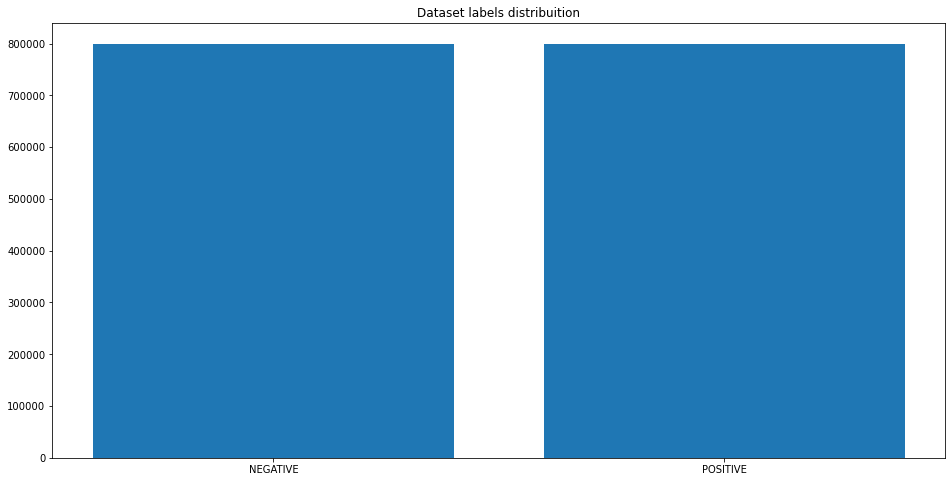

In [17]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [18]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [19]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [20]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 48s


In [21]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [22]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 4.93 s


In [23]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [24]:
w2v_model.build_vocab(documents)

2020-08-08 19:58:26,741 : INFO : collecting all words and their counts
2020-08-08 19:58:26,743 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-08-08 19:58:26,788 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-08-08 19:58:26,812 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-08-08 19:58:26,841 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-08-08 19:58:26,883 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-08-08 19:58:26,919 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-08-08 19:58:26,972 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-08-08 19:58:27,018 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-08-08 19:58:27,059 : INFO : PROGRESS: at s

2020-08-08 19:58:30,703 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-08-08 19:58:30,755 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-08-08 19:58:30,804 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-08-08 19:58:30,851 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-08-08 19:58:30,896 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-08-08 19:58:30,944 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-08-08 19:58:30,993 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-08-08 19:58:31,038 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-08-08 19:58:31,096 : INFO : PROGRESS: at sentence #800000, processed 577088

In [25]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [26]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-08-08 19:59:40,959 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-08-08 19:59:42,027 : INFO : EPOCH 1 - PROGRESS: at 5.32% examples, 426642 words/s, in_qsize 14, out_qsize 1
2020-08-08 19:59:43,036 : INFO : EPOCH 1 - PROGRESS: at 10.75% examples, 434097 words/s, in_qsize 15, out_qsize 2
2020-08-08 19:59:44,049 : INFO : EPOCH 1 - PROGRESS: at 16.48% examples, 444558 words/s, in_qsize 14, out_qsize 1
2020-08-08 19:59:45,077 : INFO : EPOCH 1 - PROGRESS: at 22.01% examples, 443916 words/s, in_qsize 14, out_qsize 1
2020-08-08 19:59:46,142 : INFO : EPOCH 1 - PROGRESS: at 27.10% examples, 433379 words/s, in_qsize 11, out_qsize 4
2020-08-08 19:59:47,144 : INFO : EPOCH 1 - PROGRESS: at 32.84% examples, 439651 words/s, in_qsize 15, out_qsize 0
2020-08-08 19:59:48,153 : INFO : EPOCH 1 - PROGRESS: at 39.43% examples, 453577 words/s, in_qsize 15, out_qsize 0
2020-08-08 19:59:49,175 : INFO : EPOCH 1 - PROGRESS: 

2020-08-08 20:00:33,621 : INFO : EPOCH 4 - PROGRESS: at 11.30% examples, 456505 words/s, in_qsize 16, out_qsize 1
2020-08-08 20:00:34,631 : INFO : EPOCH 4 - PROGRESS: at 17.57% examples, 474599 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:00:35,684 : INFO : EPOCH 4 - PROGRESS: at 23.19% examples, 465688 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:00:36,700 : INFO : EPOCH 4 - PROGRESS: at 29.37% examples, 472577 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:00:37,736 : INFO : EPOCH 4 - PROGRESS: at 35.64% examples, 476911 words/s, in_qsize 15, out_qsize 2
2020-08-08 20:00:38,763 : INFO : EPOCH 4 - PROGRESS: at 42.78% examples, 490583 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:00:39,772 : INFO : EPOCH 4 - PROGRESS: at 49.38% examples, 496488 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:00:40,791 : INFO : EPOCH 4 - PROGRESS: at 55.32% examples, 494814 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:00:41,836 : INFO : EPOCH 4 - PROGRESS: at 61.60% examples, 494787 words/s,

2020-08-08 20:01:25,927 : INFO : EPOCH 7 - PROGRESS: at 23.52% examples, 471517 words/s, in_qsize 15, out_qsize 1
2020-08-08 20:01:26,990 : INFO : EPOCH 7 - PROGRESS: at 29.59% examples, 471000 words/s, in_qsize 16, out_qsize 2
2020-08-08 20:01:27,991 : INFO : EPOCH 7 - PROGRESS: at 36.18% examples, 482679 words/s, in_qsize 16, out_qsize 0
2020-08-08 20:01:29,040 : INFO : EPOCH 7 - PROGRESS: at 42.35% examples, 482844 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:01:30,060 : INFO : EPOCH 7 - PROGRESS: at 48.84% examples, 487954 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:01:31,068 : INFO : EPOCH 7 - PROGRESS: at 55.10% examples, 490686 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:01:32,075 : INFO : EPOCH 7 - PROGRESS: at 61.50% examples, 493776 words/s, in_qsize 16, out_qsize 1
2020-08-08 20:01:33,089 : INFO : EPOCH 7 - PROGRESS: at 67.66% examples, 494308 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:01:34,122 : INFO : EPOCH 7 - PROGRESS: at 73.19% examples, 489804 words/s,

2020-08-08 20:02:18,897 : INFO : EPOCH 10 - PROGRESS: at 34.78% examples, 465497 words/s, in_qsize 16, out_qsize 1
2020-08-08 20:02:19,980 : INFO : EPOCH 10 - PROGRESS: at 41.16% examples, 468458 words/s, in_qsize 13, out_qsize 2
2020-08-08 20:02:21,034 : INFO : EPOCH 10 - PROGRESS: at 47.65% examples, 473398 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:02:22,034 : INFO : EPOCH 10 - PROGRESS: at 53.81% examples, 477075 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:02:23,058 : INFO : EPOCH 10 - PROGRESS: at 60.09% examples, 479818 words/s, in_qsize 16, out_qsize 1
2020-08-08 20:02:24,075 : INFO : EPOCH 10 - PROGRESS: at 66.04% examples, 480045 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:02:25,079 : INFO : EPOCH 10 - PROGRESS: at 71.78% examples, 479248 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:02:26,090 : INFO : EPOCH 10 - PROGRESS: at 77.52% examples, 478284 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:02:27,124 : INFO : EPOCH 10 - PROGRESS: at 84.05% examples, 481069

2020-08-08 20:03:09,888 : INFO : EPOCH 13 - PROGRESS: at 40.29% examples, 463783 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:03:10,905 : INFO : EPOCH 13 - PROGRESS: at 46.57% examples, 469230 words/s, in_qsize 13, out_qsize 2
2020-08-08 20:03:11,915 : INFO : EPOCH 13 - PROGRESS: at 52.29% examples, 469117 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:03:12,947 : INFO : EPOCH 13 - PROGRESS: at 57.49% examples, 463594 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:03:13,982 : INFO : EPOCH 13 - PROGRESS: at 62.36% examples, 456567 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:03:15,032 : INFO : EPOCH 13 - PROGRESS: at 67.88% examples, 454549 words/s, in_qsize 16, out_qsize 0
2020-08-08 20:03:16,044 : INFO : EPOCH 13 - PROGRESS: at 73.73% examples, 456104 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:03:17,076 : INFO : EPOCH 13 - PROGRESS: at 79.81% examples, 458070 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:03:18,081 : INFO : EPOCH 13 - PROGRESS: at 85.13% examples, 456513

2020-08-08 20:04:01,289 : INFO : EPOCH 16 - PROGRESS: at 39.54% examples, 455202 words/s, in_qsize 14, out_qsize 3
2020-08-08 20:04:02,302 : INFO : EPOCH 16 - PROGRESS: at 44.18% examples, 445660 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:04:03,333 : INFO : EPOCH 16 - PROGRESS: at 49.81% examples, 446052 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:04:04,374 : INFO : EPOCH 16 - PROGRESS: at 55.75% examples, 448610 words/s, in_qsize 16, out_qsize 1
2020-08-08 20:04:05,385 : INFO : EPOCH 16 - PROGRESS: at 62.25% examples, 455843 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:04:06,387 : INFO : EPOCH 16 - PROGRESS: at 67.88% examples, 456350 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:04:07,429 : INFO : EPOCH 16 - PROGRESS: at 74.26% examples, 460088 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:04:08,485 : INFO : EPOCH 16 - PROGRESS: at 80.68% examples, 462857 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:04:09,520 : INFO : EPOCH 16 - PROGRESS: at 86.85% examples, 464717

2020-08-08 20:04:53,412 : INFO : EPOCH 19 - PROGRESS: at 24.61% examples, 486526 words/s, in_qsize 16, out_qsize 1
2020-08-08 20:04:54,441 : INFO : EPOCH 19 - PROGRESS: at 31.54% examples, 499901 words/s, in_qsize 15, out_qsize 4
2020-08-08 20:04:55,453 : INFO : EPOCH 19 - PROGRESS: at 38.46% examples, 510251 words/s, in_qsize 16, out_qsize 0
2020-08-08 20:04:56,457 : INFO : EPOCH 19 - PROGRESS: at 45.27% examples, 517034 words/s, in_qsize 16, out_qsize 0
2020-08-08 20:04:57,469 : INFO : EPOCH 19 - PROGRESS: at 52.07% examples, 521737 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:04:58,480 : INFO : EPOCH 19 - PROGRESS: at 58.58% examples, 522519 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:04:59,509 : INFO : EPOCH 19 - PROGRESS: at 65.61% examples, 526555 words/s, in_qsize 16, out_qsize 1
2020-08-08 20:05:00,511 : INFO : EPOCH 19 - PROGRESS: at 72.31% examples, 528723 words/s, in_qsize 13, out_qsize 2
2020-08-08 20:05:01,554 : INFO : EPOCH 19 - PROGRESS: at 79.71% examples, 533127

2020-08-08 20:05:44,529 : INFO : EPOCH 22 - PROGRESS: at 60.30% examples, 542276 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:05:45,535 : INFO : EPOCH 22 - PROGRESS: at 66.69% examples, 540301 words/s, in_qsize 15, out_qsize 1
2020-08-08 20:05:46,543 : INFO : EPOCH 22 - PROGRESS: at 73.84% examples, 544179 words/s, in_qsize 16, out_qsize 0
2020-08-08 20:05:47,554 : INFO : EPOCH 22 - PROGRESS: at 80.80% examples, 545816 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:05:48,614 : INFO : EPOCH 22 - PROGRESS: at 88.16% examples, 547843 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:05:49,621 : INFO : EPOCH 22 - PROGRESS: at 95.34% examples, 550355 words/s, in_qsize 16, out_qsize 0
2020-08-08 20:05:50,167 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-08-08 20:05:50,174 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-08 20:05:50,179 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-08 20:05:50,182 : INFO : work

2020-08-08 20:06:34,680 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-08-08 20:06:34,683 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-08-08 20:06:34,686 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-08-08 20:06:34,715 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-08-08 20:06:34,719 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-08 20:06:34,723 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-08 20:06:34,735 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-08 20:06:34,738 : INFO : EPOCH - 25 : training on 9227204 raw words (8222684 effective words) took 15.2s, 542724 effective words/s
2020-08-08 20:06:35,782 : INFO : EPOCH 26 - PROGRESS: at 5.00% examples, 400233 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:06:36,785 : INFO : EPOCH 26 - PROGRESS: at 10.42% examples, 421738 words/s, in_qsize 15, out_qsi

2020-08-08 20:07:23,200 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-08-08 20:07:23,206 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-08-08 20:07:23,215 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-08-08 20:07:23,216 : INFO : EPOCH - 28 : training on 9227204 raw words (8223611 effective words) took 16.5s, 498734 effective words/s
2020-08-08 20:07:24,285 : INFO : EPOCH 29 - PROGRESS: at 5.43% examples, 429798 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:07:25,289 : INFO : EPOCH 29 - PROGRESS: at 11.62% examples, 467386 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:07:26,322 : INFO : EPOCH 29 - PROGRESS: at 17.89% examples, 478223 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:07:27,361 : INFO : EPOCH 29 - PROGRESS: at 24.39% examples, 487373 words/s, in_qsize 15, out_qsize 3
2020-08-08 20:07:28,377 : INFO : EPOCH 29 - PROGRESS: at 30.56% examples, 489876 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:

2020-08-08 20:08:12,753 : INFO : EPOCH - 31 : training on 9227204 raw words (8222702 effective words) took 16.3s, 504746 effective words/s
2020-08-08 20:08:13,805 : INFO : EPOCH 32 - PROGRESS: at 6.19% examples, 491385 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:08:14,827 : INFO : EPOCH 32 - PROGRESS: at 12.71% examples, 507282 words/s, in_qsize 15, out_qsize 2
2020-08-08 20:08:15,833 : INFO : EPOCH 32 - PROGRESS: at 19.62% examples, 526742 words/s, in_qsize 16, out_qsize 0
2020-08-08 20:08:16,856 : INFO : EPOCH 32 - PROGRESS: at 24.72% examples, 497304 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:08:17,868 : INFO : EPOCH 32 - PROGRESS: at 30.02% examples, 484265 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:08:18,900 : INFO : EPOCH 32 - PROGRESS: at 35.75% examples, 479771 words/s, in_qsize 15, out_qsize 0
2020-08-08 20:08:19,923 : INFO : EPOCH 32 - PROGRESS: at 41.81% examples, 480871 words/s, in_qsize 14, out_qsize 1
2020-08-08 20:08:20,940 : INFO : EPOCH 32 - PROGRESS: at 

Wall time: 8min 47s


(263123805, 295270528)

In [27]:
w2v_model.most_similar("love")

C:\Users\DHAIRYA\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-08-08 20:08:28,755 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.57975172996521),
 ('loves', 0.5669010281562805),
 ('loved', 0.539790689945221),
 ('adore', 0.5269957780838013),
 ('amazing', 0.5069565176963806),
 ('looove', 0.49437373876571655),
 ('loveee', 0.4676706790924072),
 ('awesome', 0.4652189612388611),
 ('loooove', 0.453708291053772),
 ('lovee', 0.44821420311927795)]

In [28]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 42.2 s


In [29]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 1min 14s


In [30]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [31]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [32]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [33]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [34]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [36]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [37]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [39]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [40]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [45]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/1
1152000/1152000 [==============================] - 13703s 12ms/step - loss: 0.5029 - accuracy: 0.7516 - val_loss: 0.4697 - val_accuracy: 0.7767
Wall time: 3h 48min 23s


C:\Users\DHAIRYA\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [46]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 839s 3ms/step

ACCURACY: 0.7770500183105469
LOSS: 0.46808652911186216
Wall time: 13min 59s


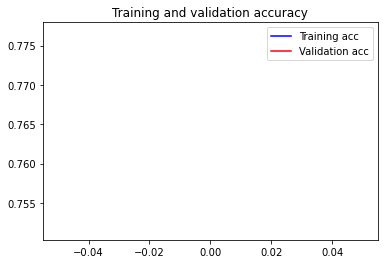

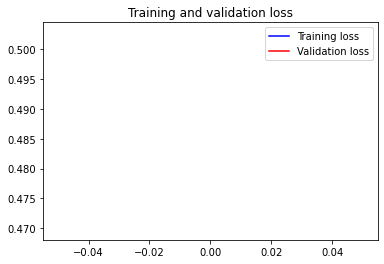

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [51]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [52]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [53]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9780962467193604,
 'elapsed_time': 1.0709960460662842}

In [78]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.01149654109030962,
 'elapsed_time': 0.044879913330078125}

In [55]:
predict("i don't know what i'm doing")

{'label': 'NEUTRAL',
 'score': 0.4863792955875397,
 'elapsed_time': 0.08693885803222656}

In [56]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 1202s 4ms/step
Wall time: 20min 6s


In [57]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

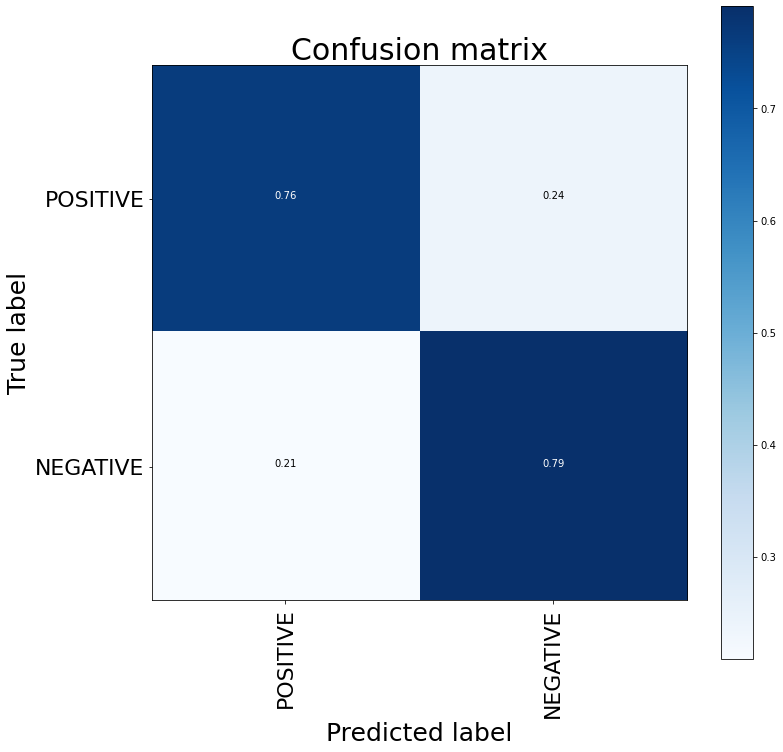

Wall time: 7.14 s


In [58]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [59]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.76      0.77    159494
    POSITIVE       0.77      0.79      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [60]:
accuracy_score(y_test_1d, y_pred_1d)

0.77705

In [81]:
model.save('model')
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

AttributeError: module 'keras.optimizers' has no attribute 'TFOptimizer'

In [80]:
w2v_model.save('w2v.h5')
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-08-09 01:43:42,132 : INFO : saving Word2Vec object under w2v.h5, separately None
2020-08-09 01:43:42,134 : INFO : not storing attribute vectors_norm
2020-08-09 01:43:42,135 : INFO : not storing attribute cum_table
2020-08-09 01:43:44,209 : INFO : saved w2v.h5
